In [27]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv('datasets/train.csv',dtype={"Age": np.float64})
test = pd.read_csv('datasets/test.csv',dtype={"Age": np.float64})
PassengerId=test['PassengerId']
all_data = pd.concat([train, test], ignore_index = True)


Percentage of females who survived:74.20
Percentage of males who survived:18.89


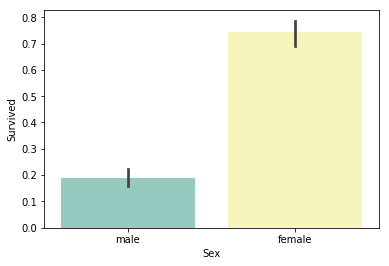

In [28]:
sns.barplot(x="Sex", y="Survived", data=train, palette='Set3')
print("Percentage of females who survived:%.2f" % (train["Survived"][train["Sex"] == 'female'].value_counts(normalize = True)[1]*100))
print("Percentage of males who survived:%.2f" % (train["Survived"][train["Sex"] == 'male'].value_counts(normalize = True)[1]*100))


Percentage of Pclass = 1 who survived:62.96
Percentage of Pclass = 2 who survived:47.28
Percentage of Pclass = 3 who survived:24.24


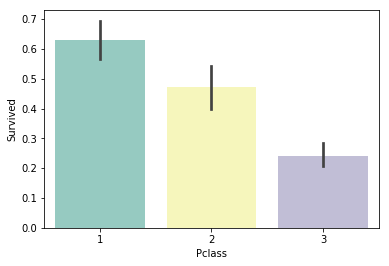

In [29]:
sns.barplot(x="Pclass", y="Survived", data=train, palette='Set3')
print("Percentage of Pclass = 1 who survived:%.2f" % (train["Survived"][train["Pclass"] == 1].value_counts(normalize = True)[1]*100))
print("Percentage of Pclass = 2 who survived:%.2f" % (train["Survived"][train["Pclass"] == 2].value_counts(normalize = True)[1]*100))
print("Percentage of Pclass = 3 who survived:%.2f" % (train["Survived"][train["Pclass"] == 3].value_counts(normalize = True)[1]*100))


In [30]:
#loading data from csv
training_data = pd.read_csv("./datasets/train.csv")
test_data = pd.read_csv("./datasets/test.csv")
gender_submission = pd.read_csv('./datasets/gender_submission.csv')

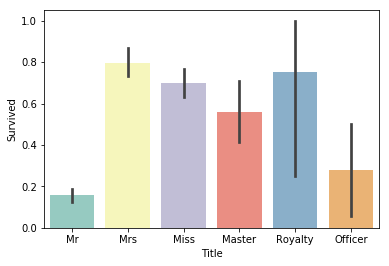

In [31]:
all_data['Title'] = all_data['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip())
Title_Dict = {}
Title_Dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
Title_Dict.update(dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
Title_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
Title_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
Title_Dict.update(dict.fromkeys(['Mr'], 'Mr'))
Title_Dict.update(dict.fromkeys(['Master','Jonkheer'], 'Master'))
all_data['Title'] = all_data['Title'].map(Title_Dict)
sns.barplot(x="Title", y="Survived", data=all_data, palette='Set3')


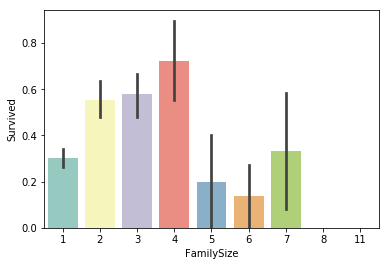

In [32]:
all_data['FamilySize']=all_data['SibSp']+all_data['Parch']+1
sns.barplot(x="FamilySize", y="Survived", data=all_data, palette='Set3')


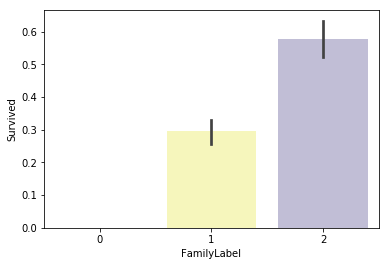

In [33]:
def Fam_label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 7)) | (s == 1):
        return 1
    elif (s > 7):
        return 0
all_data['FamilyLabel']=all_data['FamilySize'].apply(Fam_label)
sns.barplot(x="FamilyLabel", y="Survived", data=all_data, palette='Set3')


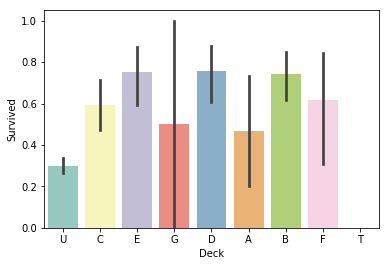

In [34]:
all_data['Cabin'] = all_data['Cabin'].fillna('Unknown')
all_data['Deck']=all_data['Cabin'].str.get(0)
sns.barplot(x="Deck", y="Survived", data=all_data, palette='Set3')


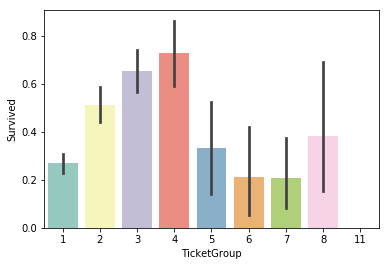

In [35]:
Ticket_Count = dict(all_data['Ticket'].value_counts())
all_data['TicketGroup'] = all_data['Ticket'].apply(lambda x:Ticket_Count[x])
sns.barplot(x='TicketGroup', y='Survived', data=all_data, palette='Set3')


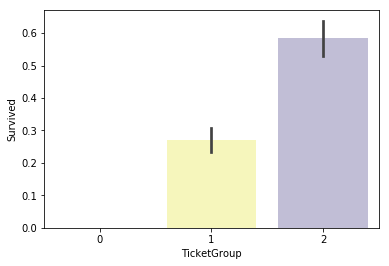

In [36]:
def Ticket_Label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 8)) | (s == 1):
        return 1
    elif (s > 8):
        return 0

all_data['TicketGroup'] = all_data['TicketGroup'].apply(Ticket_Label)
sns.barplot(x='TicketGroup', y='Survived', data=all_data, palette='Set3')


In [37]:
age_df = all_data[['Age', 'Pclass','Sex','Title']]
age_df=pd.get_dummies(age_df)
known_age = age_df[age_df.Age.notnull()].as_matrix()
unknown_age = age_df[age_df.Age.isnull()].as_matrix()
y = known_age[:, 0]
X = known_age[:, 1:]
rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)
predictedAges = rfr.predict(unknown_age[:, 1::])
all_data.loc[ (all_data.Age.isnull()), 'Age' ] = predictedAges 


In [38]:
all_data['Embarked'] = all_data['Embarked'].fillna('C')


In [39]:
fare=all_data[(all_data['Embarked'] == "S") & (all_data['Pclass'] == 3)].Fare.median()


In [40]:
all_data['Fare']=all_data['Fare'].fillna(fare)


In [41]:
all_data['Surname']=all_data['Name'].apply(lambda x:x.split(',')[0].strip())
Surname_Count = dict(all_data['Surname'].value_counts())
all_data['FamilyGroup'] = all_data['Surname'].apply(lambda x:Surname_Count[x])
Female_Child_Group=all_data.loc[(all_data['FamilyGroup']>=2) & ((all_data['Age']<=12) | (all_data['Sex']=='female'))]
Male_Adult_Group=all_data.loc[(all_data['FamilyGroup']>=2) & (all_data['Age']>12) & (all_data['Sex']=='male')]


In [43]:
Male_Adult=pd.DataFrame(Male_Adult_Group.groupby('Surname')['Survived'].mean().value_counts())
Male_Adult.columns=['GroupCount']
Male_Adult


,GroupCount
0.000000,122
1.000000,20
0.500000,6
0.333333,2
0.250000,1


In [44]:
Female_Child_Group=Female_Child_Group.groupby('Surname')['Survived'].mean()
Dead_List=set(Female_Child_Group[Female_Child_Group.apply(lambda x:x==0)].index)
print(Dead_List)
Male_Adult_List=Male_Adult_Group.groupby('Surname')['Survived'].mean()
Survived_List=set(Male_Adult_List[Male_Adult_List.apply(lambda x:x==1)].index)
print(Survived_List)


set(['Rosblom', 'Danbom', 'Oreskovic', 'Caram', 'Strom', 'Lahtinen', 'Ilmakangas', 'Rice', 'Jussila', 'Canavan', 'Turpin', 'Attalah', 'Goodwin', 'Ford', 'Lefebre', 'Arnold-Franchi', 'Panula', 'Olsson', 'Boulos', 'Bourke', 'Zabour', 'Cacic', 'Skoog', 'Johnston', 'Van Impe', 'Barbara', 'Palsson', 'Sage', 'Vander Planke', 'Lobb', 'Robins'])
set(['Kimball', 'Beane', 'Taylor', 'Nakid', 'Greenfield', 'Duff Gordon', 'Frolicher-Stehli', 'Dick', 'Harder', 'Bradley', 'McCoy', 'Beckwith', 'Jussila', 'Cardeza', 'Chambers', 'Frauenthal', 'Goldenberg', 'Daly', 'Bishop', 'Jonsson'])


In [45]:
train=all_data.loc[all_data['Survived'].notnull()]
test=all_data.loc[all_data['Survived'].isnull()]
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Sex'] = 'male'
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Age'] = 60
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Title'] = 'Mr'
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Sex'] = 'female'
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Age'] = 5
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Title'] = 'Miss'


In [46]:
all_data=pd.concat([train, test])
all_data=all_data[['Survived','Pclass','Sex','Age','Fare','Embarked','Title','FamilyLabel','Deck','TicketGroup']]
all_data=pd.get_dummies(all_data)
train=all_data[all_data['Survived'].notnull()]
test=all_data[all_data['Survived'].isnull()].drop('Survived',axis=1)
X = train.as_matrix()[:,1:]
y = train.as_matrix()[:,0]


In [47]:
pipe=Pipeline([('select',SelectKBest(k=20)), 
               ('classify', RandomForestClassifier(random_state = 10, max_features = 'sqrt'))])

param_test = {'classify__n_estimators':list(range(20,50,2)), 
              'classify__max_depth':list(range(3,60,3))}
gsearch = GridSearchCV(estimator = pipe, param_grid = param_test, scoring='roc_auc', cv=10)
gsearch.fit(X,y)
print(gsearch.best_params_, gsearch.best_score_)


({'classify__n_estimators': 42, 'classify__max_depth': 6}, 0.8810963508395343)


In [48]:
select = SelectKBest(k = 20)
clf = RandomForestClassifier(random_state = 10, warm_start = True, 
                                  n_estimators = 26,
                                  max_depth = 6, 
                                  max_features = 'sqrt')
pipeline = make_pipeline(select, clf)
pipeline.fit(X, y)


Pipeline(memory=None,
     steps=[('selectkbest', SelectKBest(k=20, score_func=<function f_classif at 0x7f1462a77410>)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0....estimators=26, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=True))])

In [51]:
importances = clf.feature_importances_
std = np.std([clf.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

1. feature 6 (0.204538)
2. feature 11 (0.198222)
3. feature 2 (0.102554)
4. feature 5 (0.099930)
5. feature 0 (0.093943)
6. feature 1 (0.086892)
7. feature 4 (0.046228)
8. feature 19 (0.036469)
9. feature 3 (0.035819)
10. feature 12 (0.018611)
11. feature 8 (0.013799)
12. feature 17 (0.012883)
13. feature 7 (0.011447)
14. feature 9 (0.010445)
15. feature 10 (0.007678)
16. feature 14 (0.007365)
17. feature 15 (0.006274)
18. feature 16 (0.003970)
19. feature 18 (0.002314)
20. feature 13 (0.000620)


IndexError: index 20 is out of bounds for axis 0 with size 20

In [24]:
cv_score = cross_validation.cross_val_score(pipeline, X, y, cv= 10)
print("CV Score : Mean - %.7g | Std - %.7g " % (np.mean(cv_score), np.std(cv_score)))


CV Score : Mean - 0.8451402 | Std - 0.03276752 


In [26]:
predictions = pipeline.predict(test)
submission = pd.DataFrame({"PassengerId": PassengerId, "Survived": predictions.astype(np.int32)})
submission.to_csv("submission.csv", index=False)


In [74]:
test_data = pd.merge(test_data, gender_submission, how='inner', on=['PassengerId', 'PassengerId'])

In [75]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


In [62]:
#for feature in training_data.columns: # Loop through all columns in the dataframe
#    if training_data[feature].dtype == 'object': # Only apply for columns with categorical strings
#        training_data[feature] = pd.Categorical(training_data[feature]).codes # Replace strings with an integer

In [76]:
training_y = training_data.pop('Survived')
testing_y = test_data.pop('Survived')

In [78]:
training_data.head()
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [83]:
for feature in training_data.columns: # Loop through all columns in the dataframe
    if training_data[feature].dtype == 'object': # Only apply for columns with categorical strings
        training_data[feature] = pd.Categorical(training_data[feature]).codes # Replace strings with an integer

for feature in test_data.columns: # Loop through all columns in the dataframe
    if test_data[feature].dtype == 'object': # Only apply for columns with categorical strings
        test_data[feature] = pd.Categorical(test_data[feature]).codes # Replace strings with an integer
        

In [86]:
xgdmat = xgb.DMatrix(training_data, training_y) # Create our DMatrix to make XGBoost more efficient


In [56]:
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 

In [87]:
final_gb = xgb.train(our_params, xgdmat, num_boost_round = 432)

[11:04:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:04:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:04:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:04:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:04:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:04:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:04:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:04:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:04:26] /work

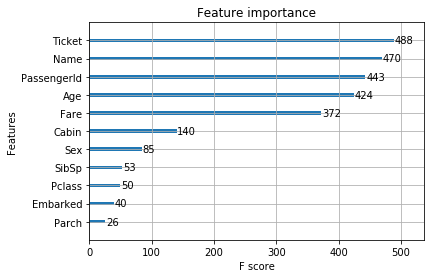

In [88]:
import matplotlib.pyplot as plt
xgb.plot_importance(final_gb)


In [90]:
print("Validating...")
check = final_gb.predict(xgb.DMatrix(test_data), ntree_limit=final_gb.best_iteration+1)


Validating...


In [93]:
from sklearn.metrics import average_precision_score

#area under the precision-recall curve
score = average_precision_score(testing_y.values, check)
print('area under the precision-recall curve: {:.6f}'.format(score))

area under the precision-recall curve: 0.810385


precision score: 0.728571
recall score: 0.671053
('Importance array: ', [('Ticket', 488), ('Name', 470), ('PassengerId', 443), ('Age', 424), ('Fare', 372), ('Cabin', 140), ('Sex', 85), ('SibSp', 53), ('Pclass', 50), ('Embarked', 40), ('Parch', 26)])
Predict test set... 
area under the precision-recall curve test set: 0.810385


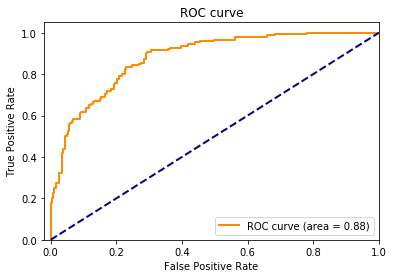

In [101]:
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
from operator import itemgetter

def get_importance(gbm, features):
    create_feature_map(features)
    importance = gbm.get_fscore(fmap='xgb.fmap')
    importance = sorted(importance.items(), key=itemgetter(1), reverse=True)
    return importance

def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()
    
check2=check.round()
score = precision_score(testing_y.values, check2)
print('precision score: {:.6f}'.format(score))

score = recall_score(testing_y.values, check2)
print('recall score: {:.6f}'.format(score))
    
imp = get_importance(final_gb, test_data.columns)
print('Importance array: ', imp)

print("Predict test set... ")
test_prediction = final_gb.predict(xgb.DMatrix(test_data), ntree_limit=final_gb.best_iteration+1)
score = average_precision_score(testing_y.values, test_prediction)

print('area under the precision-recall curve test set: {:.6f}'.format(score))
    
############################################ ROC Curve
    

 
# Compute micro-average ROC curve and ROC area
fpr, tpr, _ = roc_curve(testing_y.values, check)
roc_auc = auc(fpr, tpr)
#xgb.plot_importance(gbm)
#plt.show()
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()
##################################################